# Introduction

The following project works with a data set regarding breast cancer detection. The data set can be obtained at: https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset (link last checked in March 2025).

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

The data set contains 33 columns; 29 columns contain features and one further column contains the diagnosis, i.e. if the cells are benign or malignant. The 29 feature columns contain continous values.

The data set contains 569 rows which means it is a rather small dataset. Since unsupervised learning methods are supposed to work well even with small training data sets the data set seems to be appropriate nonetheless. The small row count has the advantage that model training is quite fast and we can do extensive parameter tuning.

Goal of the project is to predict for every row if the cells are benign or malignant. Several models (unsupervised and supervised) will be tested and compared. The problem is a classification problem for the unsupervised methods and a regression problem for the supervised methods.
 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#General sklearn imports
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

#Scalers
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler

#Unsupervised methods
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

from sklearn.decomposition import NMF, TruncatedSVD, PCA

#Supervised methods
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore") # Ignore all warnings...like some parameters in parameter tuning can not work together

In [2]:
df = pd.read_csv('Cancer_Data.csv')

# EDA and data cleaning

In [3]:
# Transposed so we do not have to scroll to the right.
df.sample(5, random_state=42).T #random state choosen in a way we have benign and malignant cases

,204,70,131,431,540
id,87930,859575,8670,907915,921385
diagnosis,B,M,M,B,B
radius_mean,12.47,18.94,15.46,12.4,11.54
texture_mean,18.6,21.31,19.48,17.68,14.44
perimeter_mean,81.09,123.6,101.7,81.47,74.65
area_mean,481.9,1130.0,748.9,467.8,402.9
smoothness_mean,0.09965,0.09009,0.1092,0.1054,0.09984
compactness_mean,0.1058,0.1029,0.1223,0.1316,0.112
concavity_mean,0.08005,0.108,0.1466,0.07741,0.06737
concave points_mean,0.03821,0.07951,0.08087,0.02799,0.02594


What we can already see in the sample is:
Most features come in three different variations with a suffix:
  - _mean: Mean value of the feature, like mean radius of the cells
  - _worst: The worst value of the feature, like the maximum radius of the cells
  - _se: Standard error of the feature --> Maybe the '_se' columns carry less information than '_worst' or '_mean'

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

We can see some problems with the data frame (except for the low number of data rows). 
- There is a column 'Unnamed: 32' which does not contain any data --> we will drop it
- Column 'Diagnosis' has the data type 'object' --> we need to change the data type
- Column 'Id' is just an identifier and not useful for any predictions. Mayve we will need it later for mapping purposes

Since all columns have 569 rows which are 'non-null and the data frame itself has 569 rows we know that **we do not have null values** any more in our data frame.

In [5]:
df = df.drop(['id','Unnamed: 32'], axis=1) #Instead of axis=1 we could set the parameter 'columns' 

In [6]:
df.diagnosis.value_counts() # Number of benign and malignant cases

diagnosis
B    357
M    212
Name: count, dtype: int64

Our data set contains more 'benign' than 'malignant' cases. An equal distribution would be better because learning algorithms 
might learn 'Benign' is a more likely.

Now we can change the data type of the 'diagnosis' column **from object to integer**. That is required e.g. for the correlation matrix which does not work on string or object.

In [7]:
mapping = {'B': 0, 'M': 1} 
df['diagnosis'] = df['diagnosis'].map(mapping)  
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

Now we can have a look at the correlation matrix. And since the correlation matrix is quite confusing with all the 29 features we can also print the most and least significant features.

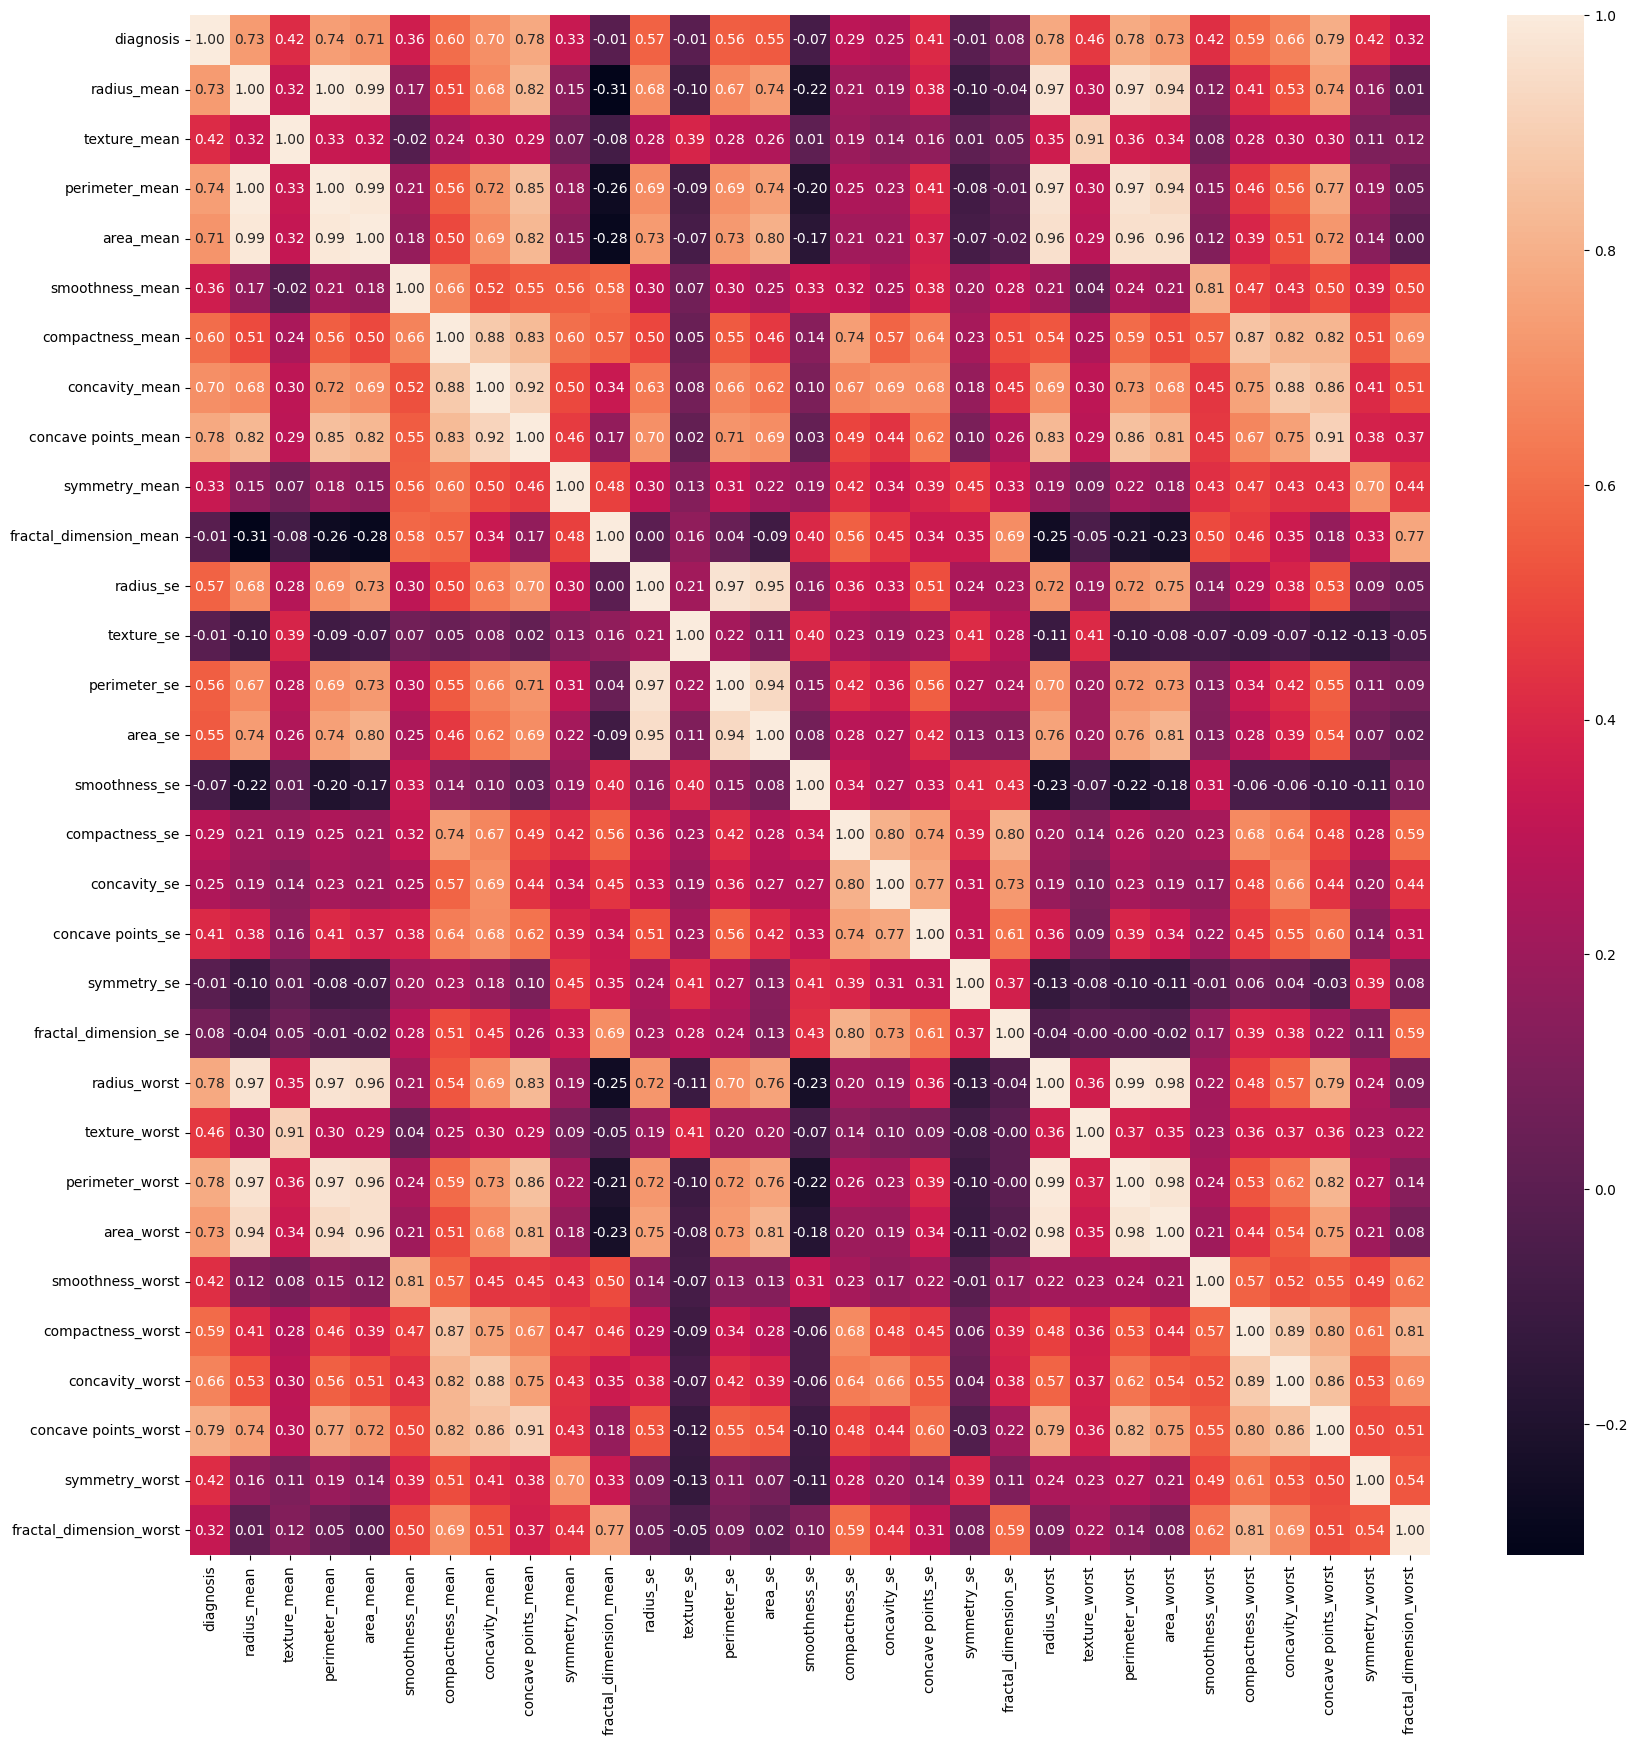

In [8]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show() # without the plt.show() we get to see the internal axes object which is returned by the heatmap function

In [9]:
corr_matrix = df.corr()
diagnosis_corr = corr_matrix['diagnosis']  
significant_corr = diagnosis_corr[abs(diagnosis_corr) > 0.6].drop('diagnosis')  
sorted_significant_corr = significant_corr.abs().sort_values(ascending=False)  
diagnosis_corr=diagnosis_corr.drop('diagnosis')
sorted_corr = diagnosis_corr.sort_values(ascending=False)  
print("Most significant features: ")
pd.DataFrame(sorted_significant_corr)

Most significant features: 


,diagnosis
concave points_worst,0.793566
perimeter_worst,0.782914
concave points_mean,0.776614
radius_worst,0.776454
perimeter_mean,0.742636
area_worst,0.733825
radius_mean,0.730029
area_mean,0.708984
concavity_mean,0.696360
concavity_worst,0.659610


In [10]:
corr_matrix = df.corr()
diagnosis_corr = corr_matrix['diagnosis']  
significant_corr = diagnosis_corr[abs(diagnosis_corr) < 0.3] 
sorted_significant_corr = significant_corr.sort_values(ascending=False)  
#diagnosis_corr=diagnosis_corr.drop('diagnosis')
sorted_corr = diagnosis_corr.sort_values(ascending=False)  
print("Least significant features: ")
pd.DataFrame(sorted_significant_corr)

Least significant features: 


,diagnosis
compactness_se,0.292999
concavity_se,0.253730
fractal_dimension_se,0.077972
symmetry_se,-0.006522
texture_se,-0.008303
fractal_dimension_mean,-0.012838
smoothness_se,-0.067016


The last tables show that five features are nearly uncorrelated with the 'diagnosis' column.

But we can do more to analyze the data set. Histogram plots and violin plots of all the features can also give an overview about which features are helpful for the prediction of the diagnosis. For example if the histogram plots of benign and malignant features are nearly congruent then the feature does not have information to distinguish between benign and malignant.

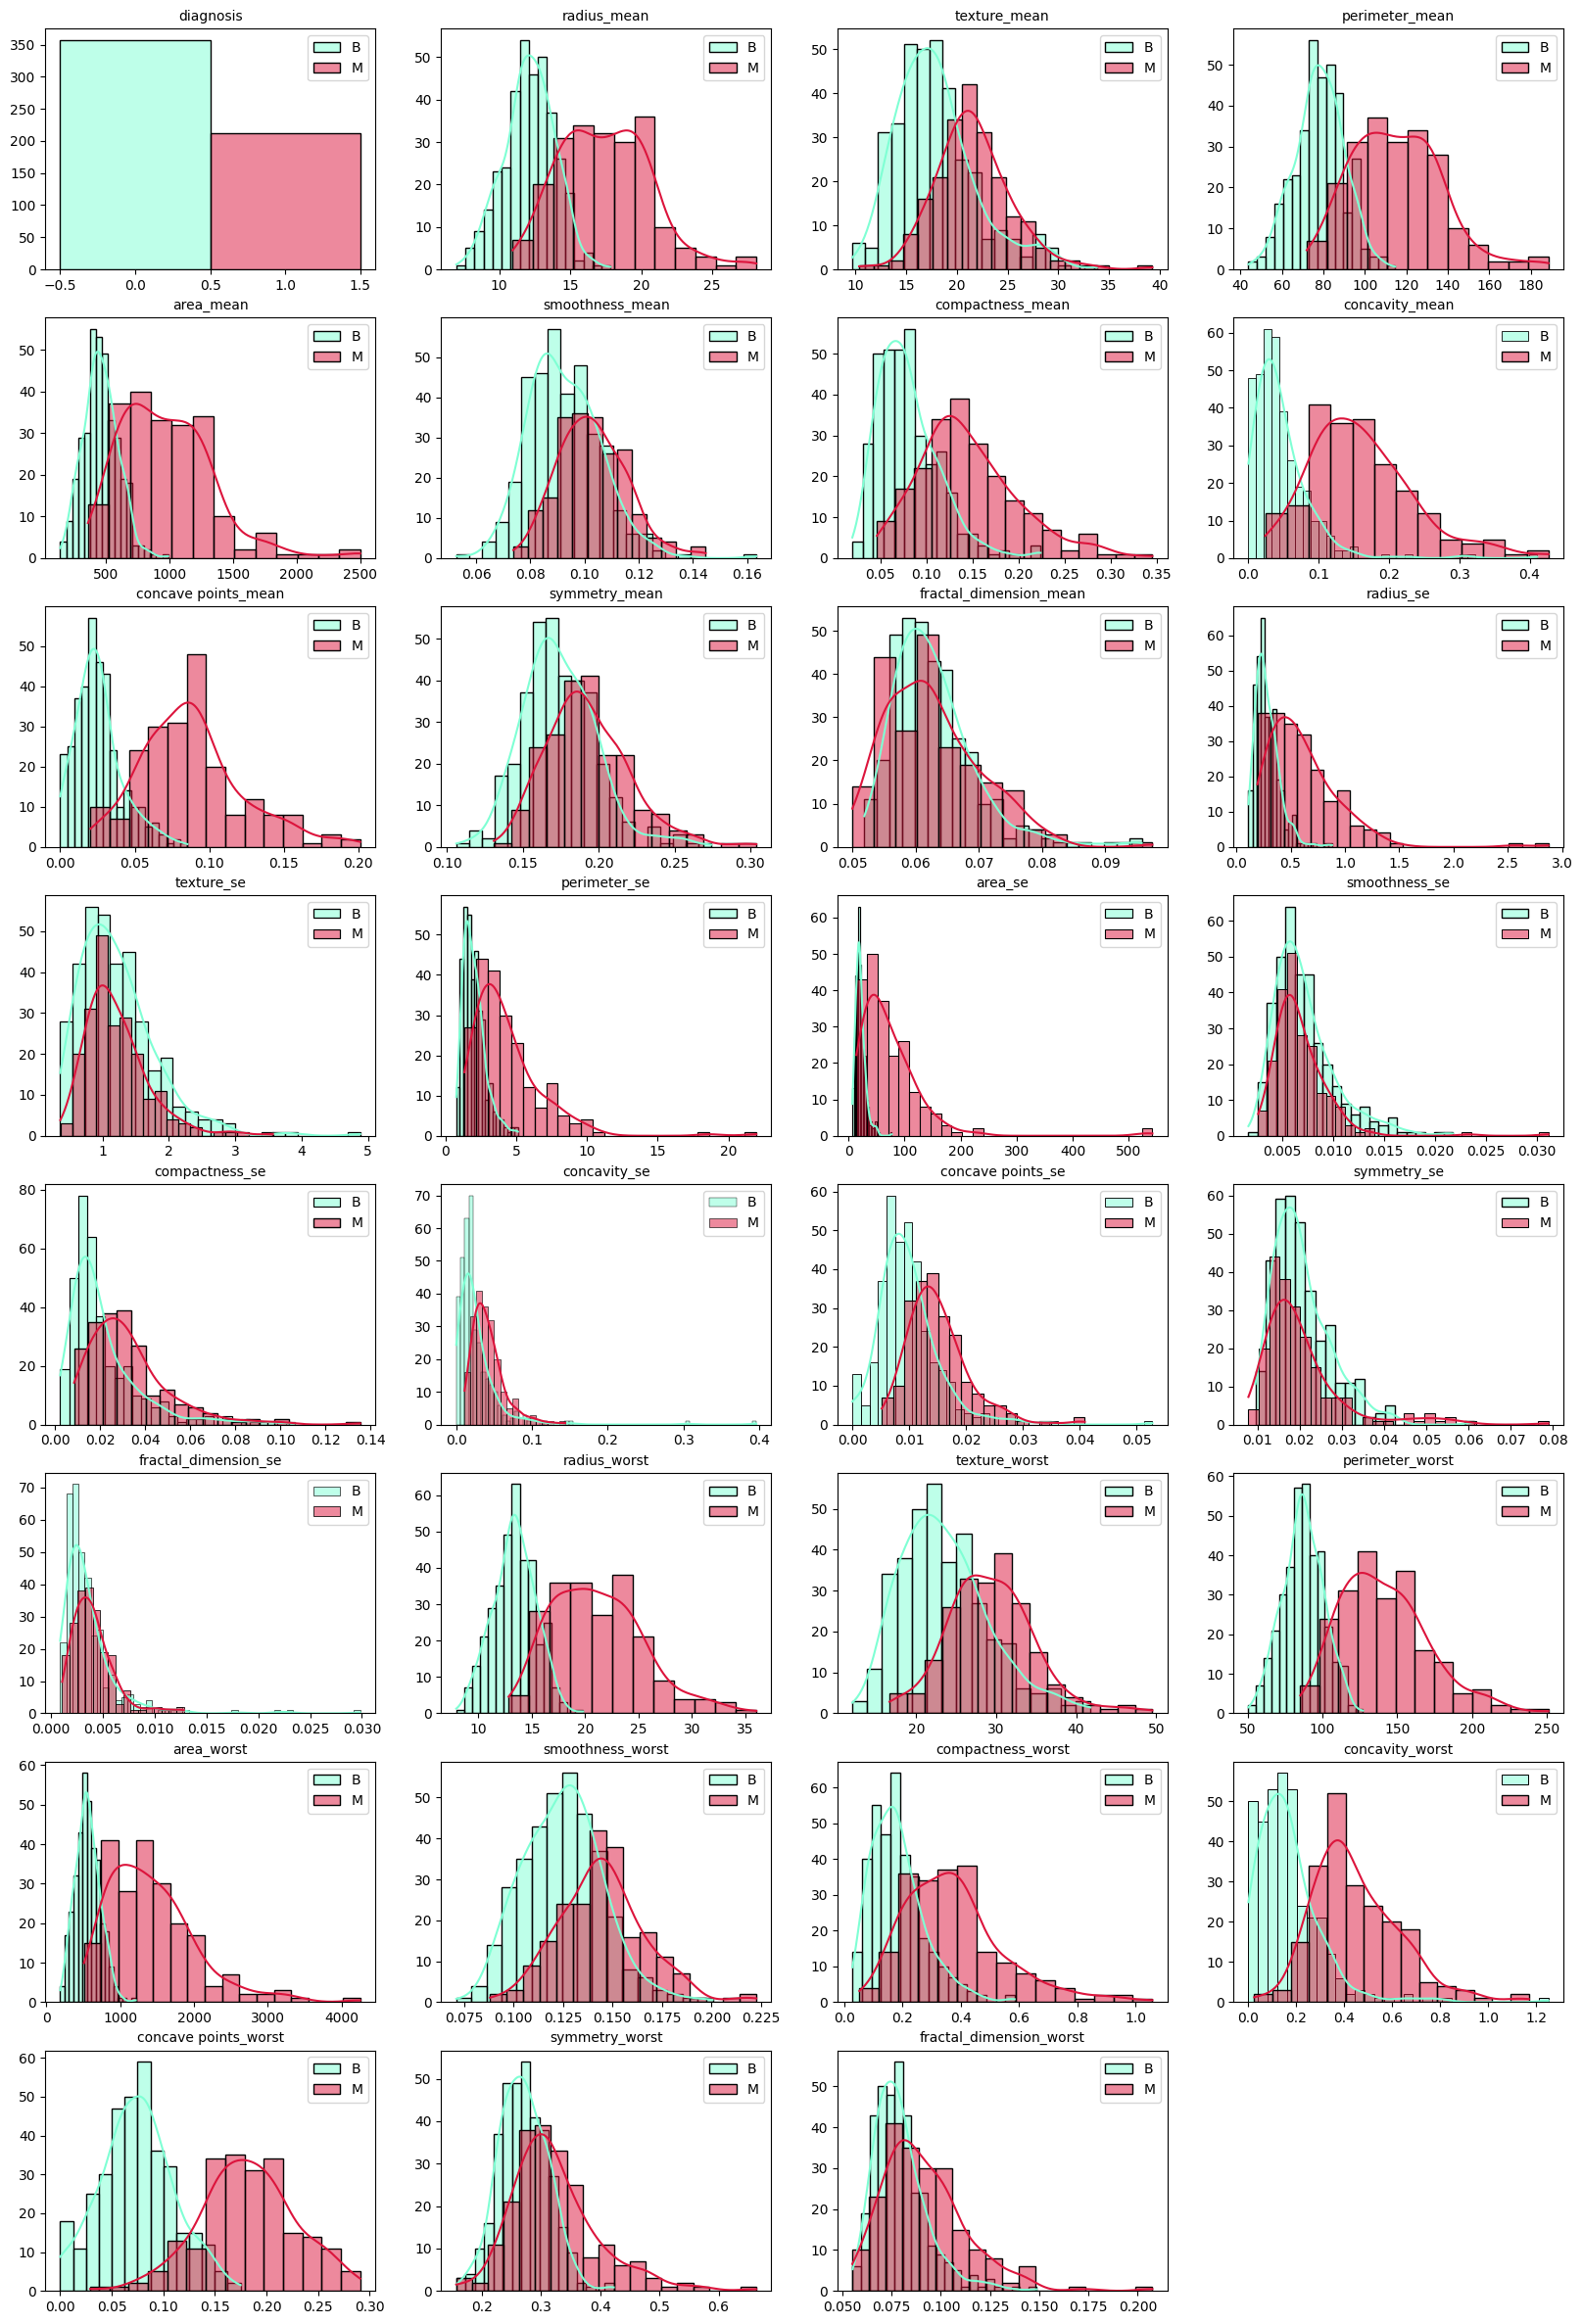

In [11]:
plt.figure(figsize=(20, 30))

for idx, col in enumerate(df.columns, 1): # def enumerate(iterable, start=0): yield n, elem
    plt.subplot(8, 4, idx) #subplots start with index 1...so we have to start our enumeration at 1
    
    b_subset = df.loc[df['diagnosis'] == 0, col]
    m_subset = df.loc[df['diagnosis'] == 1, col]
    
    sns.histplot(b_subset, label='B', color='aquamarine', kde=True)
    sns.histplot(m_subset, label='M', color='crimson', kde=True)
    plt.title(col, fontsize=10)
    plt.xlabel('') #suppress having the title on top and bottom
    plt.ylabel('') #suppress the word 'count' on the y axis
    plt.legend()

plt.show()

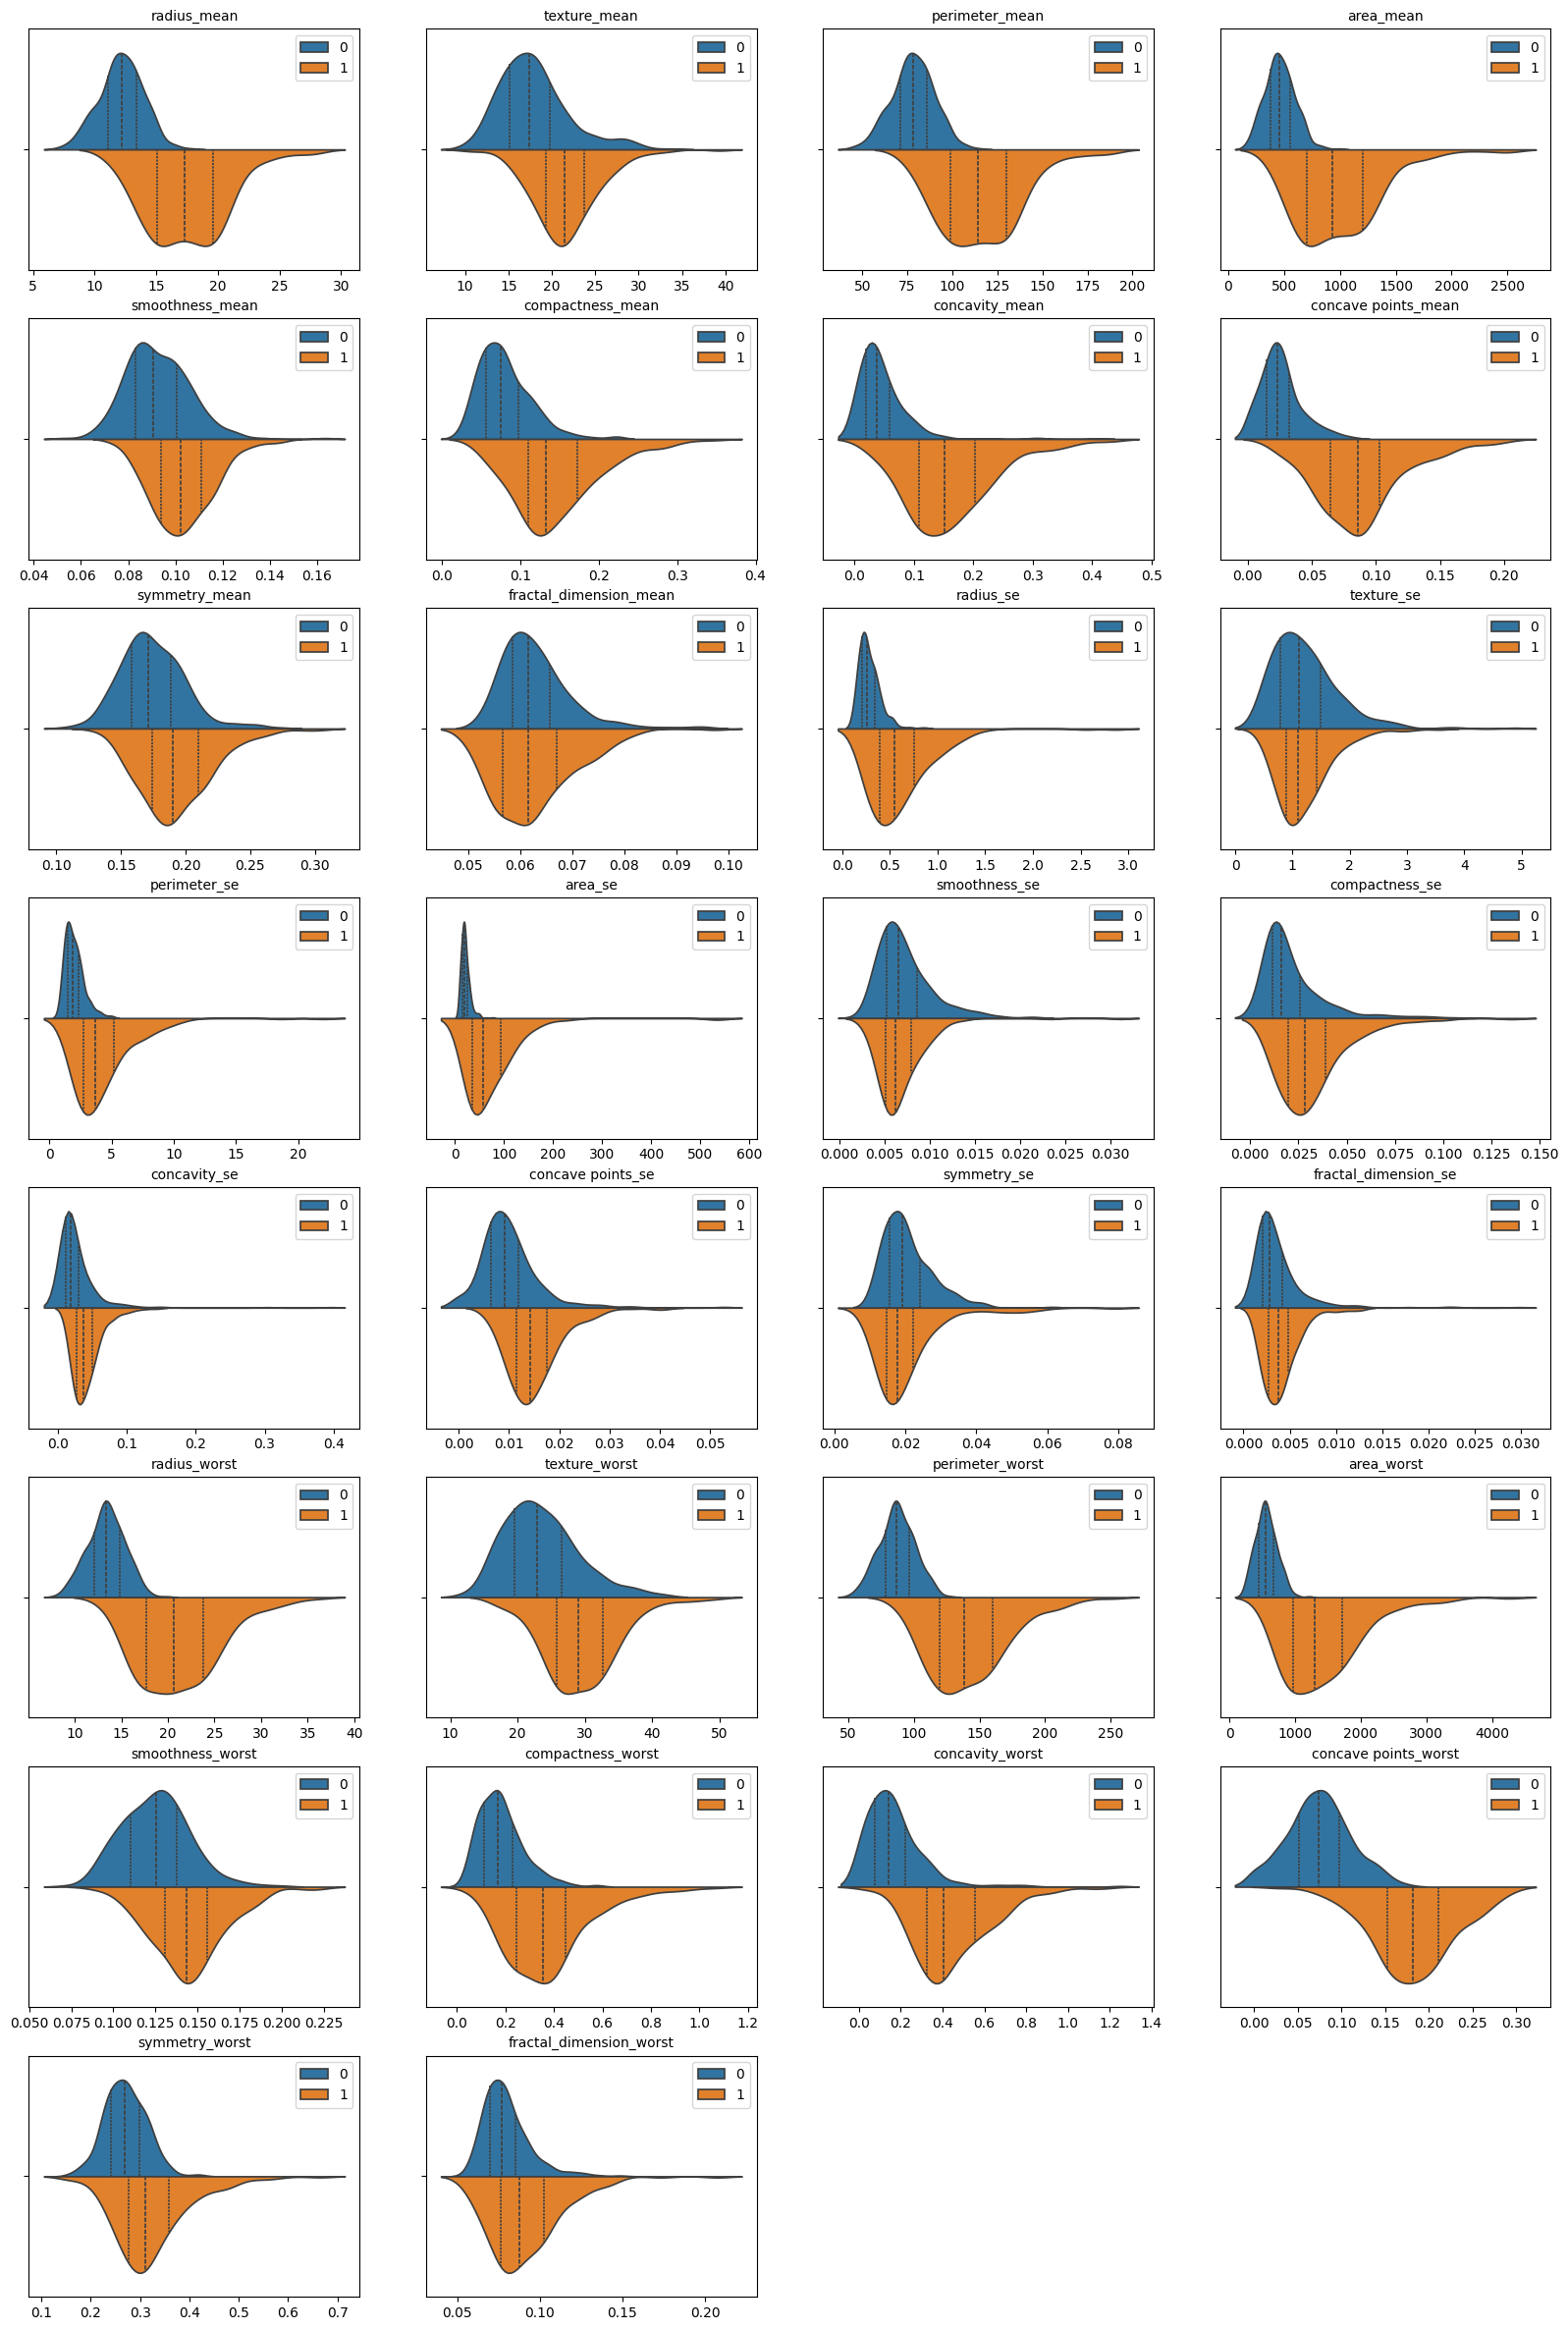

In [12]:
plt.figure(figsize=(20, 30))
columns = list(df.columns)
columns.remove('diagnosis')
for idx, col in enumerate(columns, 1):
    plt.subplot(8, 4, idx)
    
    sns.violinplot(x=col, hue="diagnosis", data=df,split=True, inner="quart")

    plt.title(col, fontsize=10)
    plt.xlabel('') #suppress having the title on top and bottom
    plt.ylabel('') #suppress the word 'count' on the y axis
    plt.legend()

plt.show()

The plots show that we have a lot of features with different distributions between bening and malignant, but we can also see there is an overlapping area for all the features. My expectation is that all methods (if properly tuned) will show good performance, most likely more than 90% accuracy.

The plots are good to get an overview but exact numbers are hard to see in the small diagrams. The following three tables show the statistics of benign, malignant and overall samples. We can use those tables to understand the clustering.

In [13]:
df[df['diagnosis']==0].describe().T  # Benign cases

,count,mean,std,min,25%,50%,75%,max
diagnosis,357.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
radius_mean,357.0,12.146524,1.780512,6.981000,11.080000,12.200000,13.370000,17.85000
texture_mean,357.0,17.914762,3.995125,9.710000,15.150000,17.390000,19.760000,33.81000
perimeter_mean,357.0,78.075406,11.807438,43.790000,70.870000,78.180000,86.100000,114.60000
area_mean,357.0,462.790196,134.287118,143.500000,378.200000,458.400000,551.100000,992.10000
smoothness_mean,357.0,0.092478,0.013446,0.052630,0.083060,0.090760,0.100700,0.16340
compactness_mean,357.0,0.080085,0.033750,0.019380,0.055620,0.075290,0.097550,0.22390
concavity_mean,357.0,0.046058,0.043442,0.000000,0.020310,0.037090,0.059990,0.41080
concave points_mean,357.0,0.025717,0.015909,0.000000,0.015020,0.023440,0.032510,0.08534
symmetry_mean,357.0,0.174186,0.024807,0.106000,0.158000,0.171400,0.189000,0.27430


In [14]:
df[df['diagnosis']==1].describe().T # malignant cases

,count,mean,std,min,25%,50%,75%,max
diagnosis,212.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000
radius_mean,212.0,17.462830,3.203971,10.950000,15.075000,17.325000,19.590000,28.11000
texture_mean,212.0,21.604906,3.779470,10.380000,19.327500,21.460000,23.765000,39.28000
perimeter_mean,212.0,115.365377,21.854653,71.900000,98.745000,114.200000,129.925000,188.50000
area_mean,212.0,978.376415,367.937978,361.600000,705.300000,932.000000,1203.750000,2501.00000
smoothness_mean,212.0,0.102898,0.012608,0.073710,0.094010,0.102200,0.110925,0.14470
compactness_mean,212.0,0.145188,0.053987,0.046050,0.109600,0.132350,0.172400,0.34540
concavity_mean,212.0,0.160775,0.075019,0.023980,0.109525,0.151350,0.203050,0.42680
concave points_mean,212.0,0.087990,0.034374,0.020310,0.064620,0.086280,0.103175,0.20120
symmetry_mean,212.0,0.192909,0.027638,0.130800,0.174050,0.189900,0.209850,0.30400


In [15]:
df.describe().T # overall cases

,count,mean,std,min,25%,50%,75%,max
diagnosis,569.0,0.372583,0.483918,0.000000,0.000000,0.000000,1.000000,1.00000
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400


Since the dimensions of the features are quite different we should use a 'Scaler' at least for some of the classification methods. E.g. area_worst has a mean value of 880 and smoothness_worst has a mean value of 0.13.

# Models
At first we need to split the data frame into features (X) and diagnosis (y).
Since clustering models do not need the y component there is no need to split the data set into a training data set and a test data set. For supervised learning methods we will use GridSearchCV which does also not require splitting the data set as it is done internally for the cross validation.

In [16]:
y = df['diagnosis'] 
X = df.drop(columns='diagnosis')

A helper method to compare models will help to avoid code duplication to some extent.

In [17]:
def AnalyzeClustering(name, y_true, y_pred, dataFrame, verbose = False):
    # Option 1: Direct mapping 0->0 and 1->1
    accuracy_direct = accuracy_score(y_true, y_pred)
    
    # Option 2: Inverted mapping 0->1 and 1-> 0)
    y_pred_inverted = 1 - y_pred
    accuracy_inverted = accuracy_score(y_true, y_pred_inverted)
    
    # Choose the mapping with the higher accuracy
    if accuracy_direct >= accuracy_inverted:
        best_mapping = 'direct'
        best_accuracy = accuracy_direct
        y_pred_mapped = y_pred
    else:
        best_mapping = 'inverted'
        best_accuracy = accuracy_inverted
        y_pred_mapped = y_pred_inverted
    
    print(f"Accuracy: {name} {best_accuracy} {best_mapping}")

    # confusion matrix display
    if verbose:
        plt.figure(figsize=(4, 3))
        cf=confusion_matrix(y_true, y_pred_mapped)
        group_names = ['True Negative','False Positive','False Negative','True Positive']
        group_counts = [value for value in cf.flatten()]
        group_percentages = ["{:.1%}".format(value/569) for value in cf.flatten()]  #569 is the number of rows
        labels = [f"{name}\n{count}\n{percent}" for name, count, percent in zip(group_names,group_counts,group_percentages)] #every cell has name, count and percentages
        labels = np.asarray(labels).reshape(2,2) #confusion matrix is 2x2
        sns.heatmap(cf, annot=labels, fmt='') #no default string formatting
    
        tmp = pd.DataFrame(dataFrame)  #we do not want to override anything in the original data frame
        tmp['predicted_label'] = y_pred #add prediction column
        
        incorrect = tmp[tmp['predicted_label'] != tmp['diagnosis']]  
        if best_mapping == "inverted":
            incorrect = tmp[tmp['predicted_label'] == tmp['diagnosis']]  
        print("Incorrect predictions:")
        print(incorrect.sample(4, random_state=42).T)
        # Remember: Malignant = 1, Benign = 0

    return name, best_accuracy

In [18]:
resultsModels = [] # We will collect the results of all models in that list

Let us start with kmeans clustering and we will see where it leads us. 

Accuracy: KMeans 0.9121265377855887 inverted
Incorrect predictions:
                                86          376         242         465
diagnosis                  1.000000    0.000000    0.000000    0.000000
radius_mean               14.480000   10.570000   11.300000   13.240000
texture_mean              21.460000   20.220000   18.190000   20.130000
perimeter_mean            94.250000   70.150000   73.930000   86.870000
area_mean                648.200000  338.300000  389.400000  542.900000
smoothness_mean            0.094440    0.090730    0.095920    0.082840
compactness_mean           0.099470    0.166000    0.132500    0.122300
concavity_mean             0.120400    0.228000    0.154800    0.101000
concave points_mean        0.049380    0.059410    0.028540    0.028330
symmetry_mean              0.207500    0.218800    0.205400    0.160100
fractal_dimension_mean     0.056360    0.084500    0.076690    0.064320
radius_se                  0.420400    0.111500    0.242800    0.281

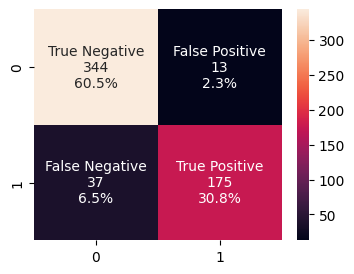

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans  = kmeans.fit(X_scaled)
kmeans_labels = kmeans.predict(X_scaled)

_, acc = AnalyzeClustering("KMeans", y, kmeans_labels ,df, True)
resultsModels.append({
            'Model': 'KMeans(2)',
            'Accuracy': acc,
            'Dim reduction': 'None',
            'Dataset size' : 'full'
            })

Please note the mapping between prediction and true diagnosis is inverted. So a prediction of 1 means actually a prediction of 0 and vice versa.

We can try and find out why sample #86 was in the cluster of mostly benign cases despite being diagnosed malignant.

In [20]:
line_86 = df.iloc[86]
line_376 = df.iloc[376]
describeMatrix = df.describe().T
meanValues = describeMatrix['mean']
meanValuesMalignant = df[df['diagnosis']==1].describe().T['mean']
meanValuesBenign = df[df['diagnosis']==0].describe().T['mean']

comparison = pd.DataFrame({'86': line_86, '376': line_376, 'meanValues': meanValues, 'meanValuesMalignant': meanValuesMalignant, 'meanValuesBenign': meanValuesBenign})
comparison['86_Minus_Means'] = (comparison['86'] - comparison['meanValues'])
comparison['376_Minus_Means'] = (comparison['376'] - comparison['meanValues'])
comparison['376_Minus_86'] = (comparison['376'] - comparison['86'])
comparison

,86,376,meanValues,meanValuesMalignant,meanValuesBenign,86_Minus_Means,376_Minus_Means,376_Minus_86
diagnosis,1.000000,0.000000,0.372583,1.000000,0.000000,0.627417,-0.372583,-1.000000
radius_mean,14.480000,10.570000,14.127292,17.462830,12.146524,0.352708,-3.557292,-3.910000
texture_mean,21.460000,20.220000,19.289649,21.604906,17.914762,2.170351,0.930351,-1.240000
perimeter_mean,94.250000,70.150000,91.969033,115.365377,78.075406,2.280967,-21.819033,-24.100000
area_mean,648.200000,338.300000,654.889104,978.376415,462.790196,-6.689104,-316.589104,-309.900000
smoothness_mean,0.094440,0.090730,0.096360,0.102898,0.092478,-0.001920,-0.005630,-0.003710
compactness_mean,0.099470,0.166000,0.104341,0.145188,0.080085,-0.004871,0.061659,0.066530
concavity_mean,0.120400,0.228000,0.088799,0.160775,0.046058,0.031601,0.139201,0.107600
concave points_mean,0.049380,0.059410,0.048919,0.087990,0.025717,0.000461,0.010491,0.010030
symmetry_mean,0.207500,0.218800,0.181162,0.192909,0.174186,0.026338,0.037638,0.011300


Looking at all the diagrams above and also the description of the data set we can see that malignant cases have in general higher values and benign cases have lower values.

The comparison above shows nearly all the features of row 86 are very close to the overall mean values. Feature 'area_worst' even has a value in row 86 that is a lot smaller than the overall mean value. 

Considering that there are more benign than malignant cases in the dataset it makes sense that the kmeans algorithm put row 86 in the cluster with mostly benign cases.

Row #376 in constrast is a benign case that was clustered in the malignant cluster. Nearly all its features have lower values than row 86. Expectation would be that row 376 is in the benign cluster. There is only a minority of features that has values higher in row 376 than in row 86. The two most promiment ones are 'concavity_worst' and 'compactness_mean'.

### Conclusion of the analysis
- As expected there are some samples whose features are somewhere in between the benign and the malignant clusters. E.g. row 86.
- There are some rows like row number 376 which - for a human being - clearly show signs of being a benign case but are clustered wrong by the clustering algorithm.
- Having a high number of features, an imbalanced data set and a low number of rows it is hardly possible to find out why samples like row 376 are in the wrong cluster.

Since we have guessed that the problem with row 376 were the features 'concavity_worst' and 'compactness_mean' we can run the clustering again without those features and confirm the suspicion.

In [21]:
X_376 = df.drop(['concavity_worst','compactness_mean'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_376)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels  = kmeans.fit(X_scaled).labels_

_, acc = AnalyzeClustering("KMeans", y, kmeans_labels ,df, False)
resultsModels.append({
            'Model': 'KMeans(2)',
            'Accuracy': acc,
            'Dim reduction': 'None',
            'Dataset size' : 'no concavity, no compactness'
            })

print("Prediction row 376:",kmeans_labels[376])
print("Prediction row 86:", kmeans_labels[86])

Accuracy: KMeans 0.9367311072056239 inverted
Prediction row 376: 1
Prediction row 86: 1


Considering the inverted mapping, now row 376 is clustered in the benign cluster. --> **Our analysis of the features which caused the misclustering were correct.**

### I will now create lots of different models. Discussion of the results will happen at the very end. A reader who is not interested in the code itself can skip the next part and jump to the end of the document for the analysis.

In [22]:
scaler = StandardScaler ()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

kmeans_pca = KMeans(n_clusters=2, random_state=42)
kmeans_pca_labels = kmeans_pca.fit_predict(X_pca)

_, acc = AnalyzeClustering("KMeans/PCA 3", y, kmeans_pca_labels ,df)

resultsModels.append({
            'Model': 'KMeans(2)',
            'Accuracy': acc,
            'Dim reduction': 'PCA(3 components)',
            'Dataset size' : 'full'
            })

Accuracy: KMeans/PCA 3 0.9103690685413005 inverted


In [23]:
scaler = StandardScaler ()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

kmeans_pca = KMeans(n_clusters=2, random_state=42)
kmeans_pca_labels = kmeans_pca.fit_predict(X_pca)

_, acc = AnalyzeClustering("KMeans/PCA 5", y, kmeans_pca_labels ,df)

resultsModels.append({
            'Model': 'KMeans(2)',
            'Accuracy': acc,
            'Dim reduction': 'PCA(5 components)',
            'Dataset size' : 'full'
            })

Accuracy: KMeans/PCA 5 0.9103690685413005 inverted


In [24]:
scaler = StandardScaler ()
X_scaled = scaler.fit_transform(X)
#truncated singular value decomposition 
# Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. 
# This means it can work with sparse matrices efficiently.
svd = TruncatedSVD(n_components=3, random_state=42) 
X_svd = svd.fit_transform(X_scaled)

kmeans_svd = KMeans(n_clusters=2, random_state=42)
kmeans_svd_labels = kmeans_svd.fit_predict(X_svd)

_, acc = AnalyzeClustering("KMeans/TruncatedSVD 3", y, kmeans_svd_labels ,df)

resultsModels.append({
            'Model': 'KMeans(2)',
            'Accuracy': acc,
            'Dim reduction': 'SVD(3 components)',
            'Dataset size' : 'full'
            })

Accuracy: KMeans/TruncatedSVD 3 0.9103690685413005 inverted


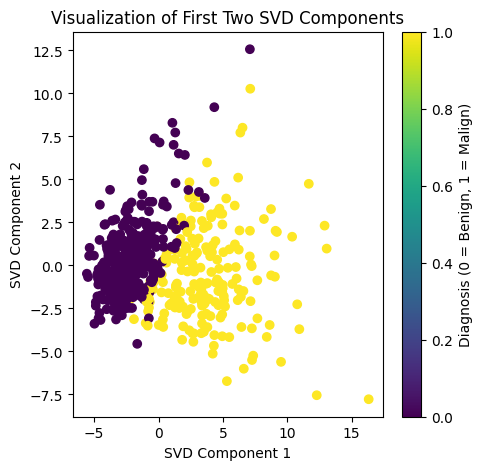

In [25]:
plt.figure(figsize=(5, 5))
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y)
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('Visualization of First Two SVD Components')
plt.colorbar(label='Diagnosis (0 = Benign, 1 = Malign)')
plt.show()

In [26]:
from sklearn.manifold import TSNE

scaler = StandardScaler ()
X_scaled = scaler.fit_transform(X)

#T-distributed Stochastic Neighbor Embedding.
#t-SNE [1] is a tool to visualize high-dimensional data. 
# It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence 
# between the joint probabilities of the low-dimensional embedding and the high-dimensional data. 
# t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.
tsne = TSNE(n_components=3, random_state=42) #n_components >= 4 results in an error message
X_Tsne = tsne.fit_transform(X_scaled)

kmeans_tsne = KMeans(n_clusters=2, random_state=42)
kmeans_tsne_labels = kmeans_tsne.fit_predict(X_Tsne)

_, acc = AnalyzeClustering("KMeans/TSNE 3", y, kmeans_tsne_labels ,df)
resultsModels.append({
            'Model': 'KMeans(2)',
            'Accuracy': acc,
            'Dim reduction': 'TSNE(3 components)',
            'Dataset size' : 'full'
            })

Accuracy: KMeans/TSNE 3 0.9209138840070299 inverted


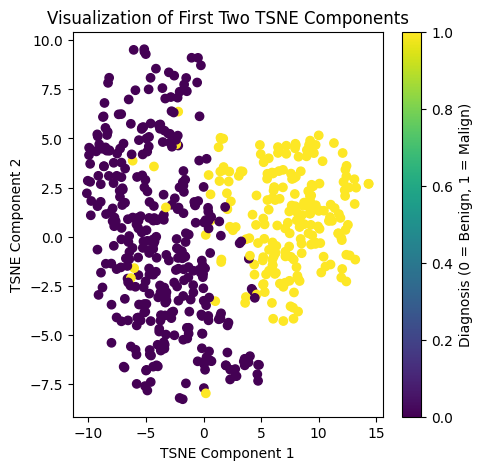

In [27]:
plt.figure(figsize=(5, 5))
plt.scatter(X_Tsne[:, 0], X_Tsne[:, 1], c=y)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('Visualization of First Two TSNE Components')
plt.colorbar(label='Diagnosis (0 = Benign, 1 = Malign)')
plt.show()

In [28]:
scaler = MinMaxScaler ()
X_scaled = scaler.fit_transform(X)
# Non-Negative Matrix Factorization
# Find two non-negative matrices, i.e. matrices with all non-negative elements, (W, H) whose product approximates the non-negative matrix X. 
# This factorization can be used for example for dimensionality reduction, source separation or topic extraction.
model = NMF(n_components=2, init='random', random_state=42)
W = model.fit_transform(X_scaled)
y_pred = np.argmax(W, axis=1)
_, acc = AnalyzeClustering("NMF", y, y_pred ,X)
resultsModels.append({
            'Model': 'NMF(2)',
            'Accuracy': acc,
            'Dim reduction': 'none',
            'Dataset size' : 'full'
            })

Accuracy: NMF 0.7978910369068541 inverted


Accuracy: KMeans TSNE 3 0.9367311072056239 inverted
Incorrect predictions:
                           536       135       291        414
concave points_worst    0.1362   0.09331    0.1489    0.06575
perimeter_worst       104.3000  92.04000  109.1000  110.10000
diagnosis               1.0000   1.00000    0.0000    1.00000
predicted_label         1.0000   1.00000    0.0000    1.00000


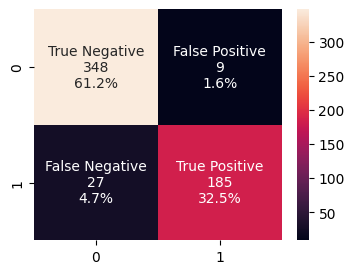

In [29]:
tinyDF = df[['concave points_worst','perimeter_worst', 'diagnosis']]
tinyDFX = tinyDF.drop('diagnosis', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tinyDFX)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans  = kmeans.fit(X_scaled)
kmeans_labels = kmeans.predict(X_scaled)

_, acc = AnalyzeClustering("KMeans TSNE 3", y, kmeans_labels ,tinyDF, True)
resultsModels.append({
            'Model': 'KMeans(2)',
            'Accuracy': acc,
            'Dim reduction': 'TSNE(3 components)',
            'Dataset size' : 'tiny'
            })

B (0)   357
M (1)   212

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tinyDFX)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans  = kmeans.fit(X_scaled)
kmeans_labels = kmeans.predict(X_scaled)

_, acc = AnalyzeClustering("KMeans", y, kmeans_labels ,tinyDF, False)
resultsModels.append({
            'Model': 'KMeans(2)',
            'Accuracy': acc,
            'Dim reduction': 'None',
            'Dataset size' : 'tiny'
            })

Accuracy: KMeans 0.9367311072056239 inverted


In [31]:
scaler = StandardScaler()
fullDatasetScaled = scaler.fit_transform(X)

tsne = TSNE(n_components=3, random_state=42) #n_components >= 4 results in an error message
X_Tsne = tsne.fit_transform(fullDatasetScaled)

metrics=['cityblock','euclidean','l1','l2','manhattan']
epsList = [0.5, 1, 1.5,2,2.5,3,5,7]
minSamplesList=[1, 3,5,10]
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
datasets = [X_Tsne, fullDatasetScaled]
datasetMap = {id(X_Tsne): "TSNE", id(fullDatasetScaled): "full"}
for eps in epsList:
    for minSamples in minSamplesList:   
        for metric in metrics:
            for algo in algorithms:
                for dataset in datasets:
                    clustering = DBSCAN(eps=eps, min_samples=minSamples, metric=metric, algorithm=algo).fit(dataset)
                    uniqueValues, count = np.unique(clustering.labels_,axis=0,return_counts=True)
                    if len(count)>2 and count[0]<50 and len(count)<10:
                        print("dataset", datasetMap[id(dataset)], "eps", eps, "minSamples", minSamples, "metric", metric, "algorithm", algo, "counts", count, "unique values", uniqueValues)

dataset TSNE eps 2 minSamples 3 metric euclidean algorithm auto counts [  3 551   5   3   7] unique values [-1  0  1  2  3]
dataset TSNE eps 2 minSamples 3 metric euclidean algorithm ball_tree counts [  3 551   5   3   7] unique values [-1  0  1  2  3]
dataset TSNE eps 2 minSamples 3 metric euclidean algorithm kd_tree counts [  3 551   5   3   7] unique values [-1  0  1  2  3]
dataset TSNE eps 2 minSamples 3 metric euclidean algorithm brute counts [  3 551   5   3   7] unique values [-1  0  1  2  3]
dataset TSNE eps 2 minSamples 3 metric l2 algorithm auto counts [  3 551   5   3   7] unique values [-1  0  1  2  3]
dataset TSNE eps 2 minSamples 3 metric l2 algorithm ball_tree counts [  3 551   5   3   7] unique values [-1  0  1  2  3]
dataset TSNE eps 2 minSamples 3 metric l2 algorithm kd_tree counts [  3 551   5   3   7] unique values [-1  0  1  2  3]
dataset TSNE eps 2 minSamples 3 metric l2 algorithm brute counts [  3 551   5   3   7] unique values [-1  0  1  2  3]
dataset TSNE eps 2

Let's remember the distribution of the data set is 357 benign and 212 malignant cases. Nearly all runs of the DBSCAN clustering had one cluster with more the 470 rows. Even if we assign that big cluster to benign and all other clusters to malignant we cannot reach an acceptable accuracy.

The DBSCAN algorithm ran with the full data set and a data set that was reduced in dimensions. The code above only prints out runs where the number of rows in the 'noisy cluster' was not relevant and the full data set did not have a single run that was printed.

--> Even varying six parameters for DBSCAN we were not able to find a set of parameters that could provide a clustering that somewhat close to the diagnosis column of the original data set.

In [32]:

scalers = [StandardScaler(), MaxAbsScaler(), MinMaxScaler(), RobustScaler()]

linkages = ['ward','complete', 'average','single']
for linkage in linkages:
    clustering = AgglomerativeClustering(n_clusters=2, linkage=linkage)
    labels  = clustering.fit_predict(X)
    
    AnalyzeClustering("AgglomerativeClustering linkage=" + linkage, y, labels ,df)
bestName = ""
bestAcc = 0.0
linkages = ['complete', 'average','single']
metrics = [ "euclidean", "l1", "l2", "manhattan", "cosine"] #precomputed works only for square matrices
for linkage in linkages:
    for metric in metrics:
        for scaler in scalers:
            X_scaled = scaler.fit_transform(X)
            clustering = AgglomerativeClustering(n_clusters=2, metric=metric, linkage=linkage) #linkage ward supports only euclidean
            labels  = clustering.fit_predict(X_scaled)
            
            name, acc = AnalyzeClustering("AgglomerativeClustering scaler=" + scaler.__class__.__name__ + " linkage=" + linkage + " metric=" + metric, y, labels ,df)
            if acc > bestAcc:
                bestAcc = acc
                bestName = name

print("-----------------------------")
print("Best model: " , bestName, bestAcc)
resultsModels.append({
            'Model': 'AgglomerativeClustering',
            'Accuracy': bestAcc,
            'Dim reduction': 'None',
            'Dataset size' : 'full'
            })

Accuracy: AgglomerativeClustering linkage=ward 0.7785588752196837 direct
Accuracy: AgglomerativeClustering linkage=complete 0.6625659050966608 inverted
Accuracy: AgglomerativeClustering linkage=average 0.6625659050966608 inverted
Accuracy: AgglomerativeClustering linkage=single 0.6291739894551845 direct
Accuracy: AgglomerativeClustering scaler=StandardScaler linkage=complete metric=euclidean 0.6309314586994728 direct
Accuracy: AgglomerativeClustering scaler=MaxAbsScaler linkage=complete metric=euclidean 0.7961335676625659 direct
Accuracy: AgglomerativeClustering scaler=MinMaxScaler linkage=complete metric=euclidean 0.7996485061511424 direct
Accuracy: AgglomerativeClustering scaler=RobustScaler linkage=complete metric=euclidean 0.6309314586994728 direct
Accuracy: AgglomerativeClustering scaler=StandardScaler linkage=complete metric=l1 0.8717047451669596 direct
Accuracy: AgglomerativeClustering scaler=MaxAbsScaler linkage=complete metric=l1 0.7785588752196837 direct
Accuracy: Agglomerati

In [33]:


scalers = [StandardScaler(), MaxAbsScaler(), MinMaxScaler(), RobustScaler()]
initParams = ['kmeans', 'k-means++', 'random', 'random_from_data']
covTypes = ['full', 'tied', 'diag', 'spherical']
bestName = ""
bestAcc = 0.0
for initParam in initParams:
    for scaler in scalers:
        for covType in covTypes:
            X_scaled = scaler.fit_transform(X)
            gmm = GaussianMixture(n_components=2, random_state=42, init_params=initParam, covariance_type=covType, n_init=3)
            gmm.fit(X_scaled)
            
            # Predict cluster labels
            labels = gmm.predict(X_scaled)
            
            name, acc = AnalyzeClustering("GaussianMixture Scaler=" + scaler.__class__.__name__ + " initParams="+initParam + " covariance_type="+covType, y, labels ,df)
            if acc > bestAcc:
                bestAcc = acc
                bestName = name
print("-----------------------------")
print("Best model: " , bestName, bestAcc)

resultsModels.append({
            'Model': 'GaussianMixture',
            'Accuracy': bestAcc,
            'Dim reduction': 'None',
            'Dataset size' : 'full'
            })

Accuracy: GaussianMixture Scaler=StandardScaler initParams=kmeans covariance_type=full 0.9402460456942003 inverted
Accuracy: GaussianMixture Scaler=StandardScaler initParams=kmeans covariance_type=tied 0.9191564147627417 inverted
Accuracy: GaussianMixture Scaler=StandardScaler initParams=kmeans covariance_type=diag 0.9121265377855887 inverted
Accuracy: GaussianMixture Scaler=StandardScaler initParams=kmeans covariance_type=spherical 0.8717047451669596 inverted
Accuracy: GaussianMixture Scaler=MaxAbsScaler initParams=kmeans covariance_type=full 0.9384885764499121 inverted
Accuracy: GaussianMixture Scaler=MaxAbsScaler initParams=kmeans covariance_type=tied 0.9209138840070299 inverted
Accuracy: GaussianMixture Scaler=MaxAbsScaler initParams=kmeans covariance_type=diag 0.9121265377855887 inverted
Accuracy: GaussianMixture Scaler=MaxAbsScaler initParams=kmeans covariance_type=spherical 0.9138840070298769 inverted
Accuracy: GaussianMixture Scaler=MinMaxScaler initParams=kmeans covariance_typ

In [34]:
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}
scaler = StandardScaler ()
X_scaled = scaler.fit_transform(X)
lr = LogisticRegression(random_state=42)

grid_search_lr = GridSearchCV(lr, param_grid=param_grid_lr, scoring='accuracy', cv=5)
grid_search_lr.fit(X_scaled, y)

print('Best LR params: ', grid_search_lr.best_params_)
print('Best LR accuracy score: ', grid_search_lr.best_score_)

resultsModels.append({
            'Model': 'LogisticRegression',
            'Accuracy': grid_search_lr.best_score_,
            'Dim reduction': 'None',
            'Dataset size' : 'full'
            })

Best LR params:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best LR accuracy score:  0.982425089271852


In [35]:
res = grid_search_lr.cv_results_['mean_test_score']
res = res[~np.isnan(res)]
res

array([0.97365316, 0.96660456, 0.97540755, 0.98242509, 0.97540755,
       0.97540755, 0.97540755, 0.97540755, 0.97542307, 0.97893184,
       0.98068623, 0.97893184, 0.98068623, 0.98068623, 0.97893184,
       0.97717746, 0.96314237, 0.97893184, 0.97015991, 0.97015991,
       0.97015991, 0.97015991, 0.97893184, 0.97893184, 0.95786369,
       0.97716193, 0.96314237, 0.96314237, 0.96314237, 0.96314237,
       0.97716193, 0.97716193])

In [36]:

param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}
scaler = MaxAbsScaler ()
X_scaled = scaler.fit_transform(X)
svc = SVC(random_state=42)

grid_search_svc = GridSearchCV(svc, param_grid=param_grid_svc, scoring='accuracy', cv=5)
grid_search_svc.fit(X_scaled, y)

print('Best LR params: ', grid_search_svc.best_params_)
print('Best LR accuracy score: ', grid_search_svc.best_score_)

resultsModels.append({
            'Model': 'SVC',
            'Accuracy': grid_search_svc.best_score_,
            'Dim reduction': 'None',
            'Dataset size' : 'full'
            })

Best LR params:  {'C': 10, 'kernel': 'rbf'}
Best LR accuracy score:  0.9771774569166279


In [37]:
res = grid_search_svc.cv_results_['mean_test_score']
res = res[~np.isnan(res)]
res

array([0.94556746, 0.97716193, 0.94907623, 0.6274181 , 0.96662009,
       0.97540755, 0.97189877, 0.50450241, 0.97014439, 0.97017544,
       0.97717746, 0.29365005, 0.96839   , 0.95783263, 0.97017544,
       0.27255085])

In [38]:
mediumSizedDF = X.drop(columns=['fractal_dimension_mean','symmetry_mean','texture_se','smoothness_se','symmetry_se', 'fractal_dimension_se','fractal_dimension_worst'])

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(mediumSizedDF)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans  = kmeans.fit(X_scaled)
kmeans_labels = kmeans.predict(X_scaled)

_, acc = AnalyzeClustering("KMeans", y, kmeans_labels ,mediumSizedDF, False)
resultsModels.append({
            'Model': 'Kmeans(2)',
            'Accuracy': acc,
            'Dim reduction': 'None',
            'Dataset size' : 'medium'
            })

Accuracy: KMeans 0.9226713532513181 inverted


In [40]:
scaler = StandardScaler ()
X_scaled = scaler.fit_transform(mediumSizedDF)

tsne = TSNE(n_components=3, random_state=42) #n_components >= 4 results in an error message
X_Tsne = tsne.fit_transform(X_scaled)

kmeans_tsne = KMeans(n_clusters=2, random_state=42)
kmeans_tsne_labels = kmeans_svd.fit_predict(X_Tsne)

_,acc = AnalyzeClustering("KMeans TSNE", y, kmeans_tsne_labels ,mediumSizedDF, False)
resultsModels.append({
            'Model': 'Kmeans(2)',
            'Accuracy': acc,
            'Dim reduction': 'TSNE(3 components)',
            'Dataset size' : 'medium'
            })

Accuracy: KMeans TSNE 0.9718804920913884 inverted


In [41]:
scaler = StandardScaler ()
X_scaled = scaler.fit_transform(mediumSizedDF)

svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_scaled)

kmeans_svd = KMeans(n_clusters=2, random_state=42)
kmeans_svd_labels = kmeans_svd.fit_predict(X_svd)

_, acc = AnalyzeClustering("KMeans TruncatedSVD", y, kmeans_svd_labels ,mediumSizedDF)
resultsModels.append({
            'Model': 'Kmeans(2)',
            'Accuracy': acc,
            'Dim reduction': 'SVD(2 components)',
            'Dataset size' : 'medium'
            })

Accuracy: KMeans TruncatedSVD 0.9191564147627417 inverted


In [42]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

_, acc = AnalyzeClustering("KMeans, no scaler", y, kmeans_labels ,mediumSizedDF)
resultsModels.append({
            'Model': 'Kmeans(2) no scaler',
            'Accuracy': acc,
            'Dim reduction': 'none',
            'Dataset size' : 'full'
            })

Accuracy: KMeans, no scaler 0.8541300527240774 inverted


In [43]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(tinyDFX)

_, acc = AnalyzeClustering("KMeans, no scaler", y, kmeans_labels ,mediumSizedDF)
resultsModels.append({
            'Model': 'Kmeans(2) no scaler',
            'Accuracy': acc,
            'Dim reduction': 'none',
            'Dataset size' : 'tiny'
            })

Accuracy: KMeans, no scaler 0.8945518453427065 inverted


In [44]:
scaler = MinMaxScaler ()
X_scaled = scaler.fit_transform(mediumSizedDF)
model = NMF(n_components=2, init='random', random_state=42)
W = model.fit_transform(X_scaled)
y_pred = np.argmax(W, axis=1)
_, acc = AnalyzeClustering("NMF", y, y_pred ,mediumSizedDF)
resultsModels.append({
            'Model': 'NMF(2)',
            'Accuracy': acc,
            'Dim reduction': 'none',
            'Dataset size' : 'medium'
            })

Accuracy: NMF 0.773286467486819 direct


In [45]:
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}
scaler = StandardScaler ()
X_scaled = scaler.fit_transform(mediumSizedDF)
lr = LogisticRegression(random_state=42)

grid_search_lr = GridSearchCV(lr, param_grid=param_grid_lr, scoring='accuracy', cv=5)
grid_search_lr.fit(X_scaled, y)

print('Best LR params: ', grid_search_lr.best_params_)
print('Best LR accuracy score: ', grid_search_lr.best_score_)

resultsModels.append({
            'Model': 'LogisticRegression',
            'Accuracy': grid_search_lr.best_score_,
            'Dim reduction': 'None',
            'Dataset size' : 'medium'
            })

Best LR params:  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best LR accuracy score:  0.9806862288464524


In [46]:
res = grid_search_lr.cv_results_['mean_test_score']
res = res[~np.isnan(res)]
res

array([0.97365316, 0.96660456, 0.97716193, 0.9806707 , 0.97716193,
       0.97716193, 0.97716193, 0.97716193, 0.97015991, 0.98068623,
       0.97893184, 0.97893184, 0.97717746, 0.97893184, 0.97717746,
       0.97893184, 0.96314237, 0.98068623, 0.96839   , 0.97015991,
       0.97015991, 0.97015991, 0.97893184, 0.97893184, 0.96489676,
       0.97893184, 0.96137246, 0.96137246, 0.96137246, 0.96137246,
       0.97893184, 0.97893184])

In [47]:
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}
scaler = StandardScaler ()
X_scaled = scaler.fit_transform(tinyDF)
lr = LogisticRegression(random_state=42)

grid_search_lr = GridSearchCV(lr, param_grid=param_grid_lr, scoring='accuracy', cv=5)
grid_search_lr.fit(X_scaled, y)

print('Best LR params: ', grid_search_lr.best_params_)
print('Best LR accuracy score: ', grid_search_lr.best_score_)

resultsModels.append({
            'Model': 'LogisticRegression',
            'Accuracy': grid_search_lr.best_score_,
            'Dim reduction': 'None',
            'Dataset size' : 'tiny'
            })

Best LR params:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best LR accuracy score:  1.0


In [48]:
res = grid_search_lr.cv_results_['mean_test_score']
res = res[~np.isnan(res)]
res

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [49]:
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}
scaler = StandardScaler ()
X_scaled = scaler.fit_transform(mediumSizedDF)
svc = SVC(random_state=42)

grid_search_svc = GridSearchCV(svc, param_grid=param_grid_svc, scoring='accuracy', cv=5)
grid_search_svc.fit(X_scaled, y)

print('Best LR params: ', grid_search_svc.best_params_)
print('Best LR accuracy score: ', grid_search_svc.best_score_)
resultsModels.append({
            'Model': 'SVC',
            'Accuracy': grid_search_svc.best_score_,
            'Dim reduction': 'None',
            'Dataset size' : 'medium'
            })

Best LR params:  {'C': 1, 'kernel': 'rbf'}
Best LR accuracy score:  0.9754075454122031


In [50]:
res = grid_search_svc.cv_results_['mean_test_score']
res = res[~np.isnan(res)]
res

array([0.97365316, 0.83837913, 0.95432386, 0.95256948, 0.97189877,
       0.91043316, 0.97540755, 0.9595715 , 0.97015991, 0.95084614,
       0.97365316, 0.93668685, 0.96135693, 0.96314237, 0.95958702,
       0.92791492])

In [51]:
param_grid_rf = { 
    'n_estimators': [100, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6],
    'criterion' :['gini', 'entropy']
}
scaler = StandardScaler ()
X_scaled = scaler.fit_transform(mediumSizedDF)
randomForest = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(randomForest, param_grid=param_grid_rf, scoring='accuracy', cv=5)
grid_search_rf.fit(X_scaled, y)

print('Best LR params: ', grid_search_rf.best_params_)
print('Best LR accuracy score: ', grid_search_rf.best_score_)
resultsModels.append({
            'Model': 'RandomForestClassifier',
            'Accuracy': grid_search_rf.best_score_,
            'Dim reduction': 'None',
            'Dataset size' : 'medium'
            })

Best LR params:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}
Best LR accuracy score:  0.9683744760130415


In [52]:
res = grid_search_rf.cv_results_['mean_test_score']
res = res[~np.isnan(res)]
res

array([0.96134141, 0.95958702, 0.95783263, 0.96134141, 0.95958702,
       0.95783263, 0.96311132, 0.96311132, 0.96135693, 0.96311132,
       0.96311132, 0.96135693, 0.96311132, 0.96488123, 0.96137246,
       0.96311132, 0.96488123, 0.96137246, 0.95430834, 0.96135693,
       0.96135693, 0.95430834, 0.96135693, 0.96135693, 0.96134141,
       0.96837448, 0.96662009, 0.96134141, 0.96837448, 0.96662009,
       0.9648657 , 0.96837448, 0.96662009, 0.9648657 , 0.96837448,
       0.96662009])

In [53]:
resultDf = pd.DataFrame(resultsModels)
resultDf.sort_values(by=['Dataset size'])

,Model,Accuracy,Dim reduction,Dataset size
0,KMeans(2),0.912127,None,full
16,Kmeans(2) no scaler,0.854130,none,full
12,SVC,0.977177,None,full
10,GaussianMixture,0.947276,None,full
9,AgglomerativeClustering,0.942004,None,full
6,NMF(2),0.797891,none,full
11,LogisticRegression,0.982425,None,full
4,KMeans(2),0.910369,SVD(3 components),full
3,KMeans(2),0.910369,PCA(5 components),full
2,KMeans(2),0.910369,PCA(3 components),full


In [54]:
resultDf.sort_values(by=['Accuracy'])

,Model,Accuracy,Dim reduction,Dataset size
18,NMF(2),0.773286,none,medium
6,NMF(2),0.797891,none,full
16,Kmeans(2) no scaler,0.854130,none,full
17,Kmeans(2) no scaler,0.894552,none,tiny
4,KMeans(2),0.910369,SVD(3 components),full
3,KMeans(2),0.910369,PCA(5 components),full
2,KMeans(2),0.910369,PCA(3 components),full
0,KMeans(2),0.912127,None,full
15,Kmeans(2),0.919156,SVD(2 components),medium
5,KMeans(2),0.920914,TSNE(3 components),full


# Model comparison and analysis


## Unsupervised vs. supervised methods in general
If a data set contains the desired output then supervised learning performs (almost always) better than unsupervised learning methods. My project about breast cancer detection also showed that rule. Supervised learning can learn where the border between the clusters is supposed to be. You can hardly tell unsupervised learning where the border is. Scaling of features and tuning the parameter of the algorithms can be used to influence the clustering but those are more indirect methods and are usually a lot of effort.

Furthermore unsupervised learning usually requires a human being to do some sanity checks of the results. My data set had a 'diagnosis' column so the sanity check was quite easy because I was able to compare predicted clusters with the diagnosis column. Such a sanity check would be much harder in a really world unsupvervised learning scenario where no diagnosis column exists. 

## Results supervised learning


All supervised learning algorithms worked very well so the data set seems to be nearly perfect for supervised learning. 
- Since the data set is quite simple, a simple algorithm like logistic regression performed really well. I used different values for 'C', 'penalty' and 'solver' and even the worst model had an accuracy of 0.96. So logistic regression was really fool proof.
- Support vector machines also performed generally well but the worst SVC model only had an accuracy of 0.83. This means the parameters for SVC have to be chosen carefully.
- Random forest classifier had an accuracy of 0.95 to 0.968 for all 36 parameter combinations. It looks like random forest had some problems finding the borders of the clusters because of the overlapping features. I found random forest to perform better on integers than on floats. Like logistic regression the performance was quite independent of the parameters but it was a lot slower than logistic regression.

--> For such a simple data set I would recommend logistic regression if the diagnosis column is available.



## Results unsupervised learning
I tried several clustering methods, several dimensionality reduction methods, several scalers and several number of features.

- Similar to supervised learning, the most simple approach (k-means clustering) showed the best results on the simple data set.
- In general dimensionality reduction did not have a big effect on the accuracy but TSNE performed a little better than SVD and PCS. E.g. on the full data set and kmeans clustering, TSNE showed an accuracy of 0.92 while PCA and SVD had an accuracy of 0.91. The difference between those methods was small though.
- Performance of DBSCAN and NMF was quite poor but DBSCAN has two parameters (eps, min_samples) which give the user good control over the clustering while the kmeans clustering can hardly be influenced by the user.
- AgglomerativeClustering and GaussianMixture were very sensitive to the parameters. While the best set of parameters led to an accuracy of greater than 0.94 there were also lots of sets of parameters with accuracy less than 0.65.
- The two worst runs for kmeans were the ones without using a scaler. Without a scaler the features with the largest numbers have the highest weight. In general there was no big difference between the scalers. Since NMF expects positive values 'MinMaxScaler' had to be used. Scaling only single features would be a way give some features higher weight.
- Manually selecting features which allows a good separation of clusters can help improve the accuracy but is a lot of manual effort.

--> While the best clustering methods showed good performance, the clustering methods were kind of unstable. Small changes in parameters led to completely different results. Having good results is only possible with a lot of manual checking and fine tuning.